### <center> Мы будем изучать методы визуализации, используя два набора данных:

In [1]:
import pandas as pd

`covid_data` — данные о показателях заболеваемости за каждый день в различных регионах 187 стран. (источник данных)

In [2]:
covid_data = pd.read_csv('data/covid_data.csv')
display(covid_data.head(3))

,date,province/state,country,confirmed,deaths,recovered
0,01/22/2020,Anhui,China,1.0,0.0,0.0
1,01/22/2020,Beijing,China,14.0,0.0,0.0
2,01/22/2020,Chongqing,China,6.0,0.0,0.0


Мы будем работать со следующими столбцами:

- `date` — дата наблюдения;
- `province/state` — наименование провинции/штата;
- `country` — наименование страны;
- `confirmed` — общее число зафиксированных случаев на указанный день;
- `deaths` — общее число зафиксированных смертей на указанный день;
- `recovered` — общее число выздоровлений на указанный день.

In [3]:
vaccinations_data = pd.read_csv('data/country_vaccinations.csv')
vaccinations_data = vaccinations_data[
    ['country', 'date', 'total_vaccinations', 
     'people_vaccinated', 'people_vaccinated_per_hundred',
     'people_fully_vaccinated', 'people_fully_vaccinated_per_hundred',
     'daily_vaccinations', 'vaccines']]
vaccinations_data.head(3)

,country,date,total_vaccinations,people_vaccinated,people_vaccinated_per_hundred,people_fully_vaccinated,people_fully_vaccinated_per_hundred,daily_vaccinations,vaccines
0,Afghanistan,2021-02-22,0.0,0.0,0.0,NaN,NaN,NaN,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi..."
1,Afghanistan,2021-02-23,NaN,NaN,NaN,NaN,NaN,1367.0,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi..."
2,Afghanistan,2021-02-24,NaN,NaN,NaN,NaN,NaN,1367.0,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi..."


Данная таблица содержит следующие столбцы:

 - `country` — наименование страны;
 - `date` — дата наблюдения;
 - `total`_vaccinations — общее число введённых вакцин в стране на указанный день;
 - `people_vaccinated` — общее число привитых первым компонентом в стране на указанный день;
 - `people_vaccinated_per_hundred` — процент привитых первым компонентом в стране на указанный день (рассчитывается как );
 - `people_fully_vaccinated` — общее число привитых вторым компонентом в стране на указанный день (первый компонент уже был введён им ранее);
 - `people_fully_vaccinated_per_hundred` — процент привитых вторым компонентом в стране на указанный день (рассчитывается как );
 - `daily_vaccination` — ежедневная вакцинация (число вакцинированных в указанный день);
 - `vaccines` — комбинации вакцин, используемые в стране.

### НЕМНОГО ОБ ОСОБЕННОСТЯХ ДАННЫХ

В таблице `covid_data` данные о заболеваемости представлены `для каждого региона (штата)` страны за каждый день. Например, `для США (United States) записи за 29 мая 2021 года` имеют вид:


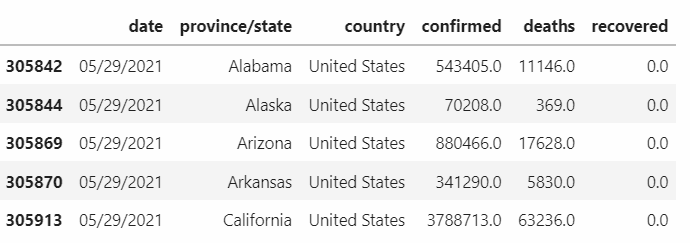

В таблице `vaccinations_data` параметры вакцинирования отображены для всех стран на каждый день, без учёта регионов. Вот часть таблицы для тех же `Соединённых Штатов за 29 мая 2021 года`. Как видите, она всего одна:

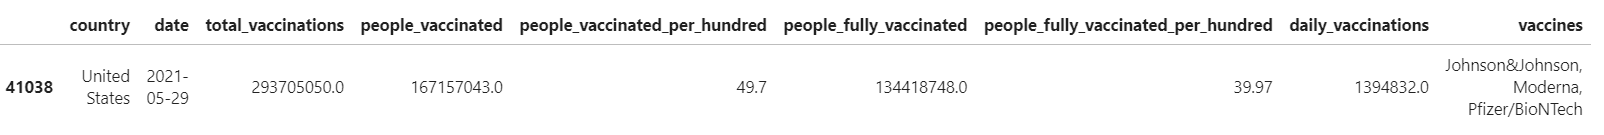

В данных много пропусков, а также неверно введённых значений. Например, для `США (United States)` и `Великобритании (United Kingdom)` в большинстве записей таблицы `covid_data` число выздоровевших людей `равно 0`. 

В данном модуле мы закроем на это глаза, но вообще эти страны подлежали бы исключению из данных или нам понадобился бы дополнительный источник данных, из которого мы смогли бы получить недостающую информацию.

Обратите внимание, что признаки `confirmed, deaths, recovered, total_vaccination, people_vaccinated, people_fully_vaccinated` — это суммарные показатели по стране, то есть с каждым днём они должны расти. Такие **признаки называют накопительными**.

### <center> ПРЕДОБРАБОТКА ДАННЫХ

Опираясь на замечания выше, выполним небольшую предобработку.

В таблице `covid_data`:

**1.** Группируем таблицу по дате и названию страны и рассчитываем суммарные показатели по всем регионам. Тем самым переходим от данных по регионам к данным по странам:

In [4]:
covid_data = covid_data.groupby(
    ['date', 'country'], 
    as_index=False
)[['confirmed', 'deaths', 'recovered']].sum()

In [5]:
covid_data.head(2)

,date,country,confirmed,deaths,recovered
0,01/01/2021,Afghanistan,51526.0,2191.0,41727.0
1,01/01/2021,Albania,58316.0,1181.0,33634.0


**2.** Преобразуем даты в формат ё с помощью функции `pd.to_datetime()`:

In [6]:
covid_data['date'] = pd.to_datetime(covid_data['date'])

**3.** Создадим признак больных на данный момент `(active)`. Для этого вычтем из общего числа зафиксированных случаев число смертей и число выздоровевших пациентов:

In [7]:
covid_data['active'] = covid_data['confirmed'] - covid_data['deaths'] - covid_data['recovered']

**4.** Создадим признак ежедневного прироста числа заболевших, умерших и выздоровевших людей. Для этого отсортируем данные по названиям стран, а затем по датам. После этого произведём группировку по странам и рассчитаем разницу между «вчера и сегодня» с помощью метода `diff()`:

In [8]:
covid_data = covid_data.sort_values(by=['country', 'date'])
covid_data['daily_confirmed'] = covid_data.groupby('country')['confirmed'].diff()
covid_data['daily_deaths'] = covid_data.groupby('country')['deaths'].diff()
covid_data['daily_recovered'] = covid_data.groupby('country')['recovered'].diff()

Итоговый вид таблицы covid_data:

In [9]:
covid_data.head(5)

,date,country,confirmed,deaths,recovered,active,daily_confirmed,daily_deaths,daily_recovered
11337,2020-02-24,Afghanistan,1.0,0.0,0.0,1.0,NaN,NaN,NaN
11570,2020-02-25,Afghanistan,1.0,0.0,0.0,1.0,0.0,0.0,0.0
11807,2020-02-26,Afghanistan,1.0,0.0,0.0,1.0,0.0,0.0,0.0
12051,2020-02-27,Afghanistan,1.0,0.0,0.0,1.0,0.0,0.0,0.0
12299,2020-02-28,Afghanistan,1.0,0.0,0.0,1.0,0.0,0.0,0.0


В таблице vaccinations_data достаточно будет преобразовать столбцы в формат datetime:

In [10]:
vaccinations_data['date'] = pd.to_datetime(vaccinations_data['date'])

In [11]:
vaccinations_data.head(5)

,country,date,total_vaccinations,people_vaccinated,people_vaccinated_per_hundred,people_fully_vaccinated,people_fully_vaccinated_per_hundred,daily_vaccinations,vaccines
0,Afghanistan,2021-02-22,0.0,0.0,0.0,NaN,NaN,NaN,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi..."
1,Afghanistan,2021-02-23,NaN,NaN,NaN,NaN,NaN,1367.0,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi..."
2,Afghanistan,2021-02-24,NaN,NaN,NaN,NaN,NaN,1367.0,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi..."
3,Afghanistan,2021-02-25,NaN,NaN,NaN,NaN,NaN,1367.0,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi..."
4,Afghanistan,2021-02-26,NaN,NaN,NaN,NaN,NaN,1367.0,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi..."


### Задание 3.1

За какой период представлены данные в таблице `covid_data`? В качестве ответа введите даты в формате `datetime` (без указания времени).
Введите ответ в следующем формате (без пробелов): `ГГГГ-ММ-ДД-ГГГГ-ММ-ДД`

In [12]:
covid_data['date'].min()

Timestamp('2020-01-22 00:00:00')

In [13]:
covid_data['date'].max()
# covid_data['date'].sort_values()

Timestamp('2021-05-29 00:00:00')

### Задание 3.2

За какой период представлены данные в таблице `vaccinations_data`? В качестве ответа введите даты в формате `datetime` без указания времени.
Введите ответ в следующем формате (без пробелов): `ГГГГ-ММ-ДД-ГГГГ-ММ-ДД`

In [14]:
vaccinations_data['date'].min()

Timestamp('2020-12-02 00:00:00')

In [15]:
vaccinations_data['date'].max()

Timestamp('2021-09-06 00:00:00')

### Задание 3.3

С помощью метода `merge()` объедините таблицы `covid_data` и `vaccinations_data` по столбцам `date` и `country`.
Тип объединения выставьте так, чтобы в результирующую таблицу попали только наблюдения за период, вычисленный в `задании 3.1`. То есть в результирующую таблицу должны попасть все записи из таблицы `covid_data` и из её пересечения с `vaccinations_data`, но не более. Результат объединения занесите в переменную `covid_df`.
Сохраните таблицу `covid_df` — она понадобится нам в следующем юните.

Сколько строк и столбцов в таблице `covid_df`?
Введите ответ в виде двух чисел через дефис `(например, 333-33)`: первое число — количество строк, второе число — количество столбцов.

In [16]:
covid_df = covid_data.merge(vaccinations_data, on=['date', 'country'], how='left')

In [17]:
covid_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86785 entries, 0 to 86784
Data columns (total 16 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   date                                 86785 non-null  datetime64[ns]
 1   country                              86785 non-null  object        
 2   confirmed                            86785 non-null  float64       
 3   deaths                               86785 non-null  float64       
 4   recovered                            86785 non-null  float64       
 5   active                               86785 non-null  float64       
 6   daily_confirmed                      86564 non-null  float64       
 7   daily_deaths                         86564 non-null  float64       
 8   daily_recovered                      86564 non-null  float64       
 9   total_vaccinations                   10629 non-null  float64       
 10  people_vac

В получившейся в задании 3.3 таблице `covid_df` создайте признаки `death_rate` — общий процент смертей среди зафиксированных случаев (летальность) и `recover_rate` — общий процент случаев выздоровления. Данные характеристики рассчитайте как отношение числа смертей `(deaths)` и числа выздоровлений `(recovered)` к числу зафиксированных случаев `(confirmed)` и умножьте результаты на 100%.

In [18]:
covid_df['death_rate'] = ((covid_df['deaths'] / covid_df['confirmed']) * 100)  #.round()
covid_df['recover_rate'] = ((covid_df['recovered'] / covid_df['confirmed']) * 100)  #.round()

In [19]:
covid_df.head()

,date,country,confirmed,deaths,recovered,active,daily_confirmed,daily_deaths,daily_recovered,total_vaccinations,people_vaccinated,people_vaccinated_per_hundred,people_fully_vaccinated,people_fully_vaccinated_per_hundred,daily_vaccinations,vaccines,death_rate,recover_rate
0,2020-02-24,Afghanistan,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
1,2020-02-25,Afghanistan,1.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2,2020-02-26,Afghanistan,1.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
3,2020-02-27,Afghanistan,1.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
4,2020-02-28,Afghanistan,1.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0


### Задание 3.4

Какова максимальная летальность в США `(United States)` за весь период? Ответ округлите до второго знака после запятой

In [20]:
round(covid_df[covid_df['country'] == 'United States']['death_rate'].max(), 2)

7.19

### Задание 3.5

Чему равен средний процент выздоровевших в `России (Russia)`? Ответ округлите до второго знака после запятой.

In [21]:
round(covid_df[covid_df['country'] == 'Russia']['recover_rate'].mean(), 2)

67.06

### **Сохраняем наш dataFrame в файл .csv**

In [22]:
covid_df.to_csv('data/covid_df.csv', index=False, sep=';')

---